### Allen Cahn in JAX

$\begin{aligned}
	&u_t - 0.0001u_{xx} + 5u^3 - 5u = 0, \quad t\in[0,1],x\in[-1,1], \\
	&u(x,0) = x^2\cos(\pi x), \\
	&u(t,-1) = u(t,1),\\
	&u_x(t,-1) = u_x(t,1).
\end{aligned}$

### Acknowledgments

The following sections contain code that is based on the original work by Sifan Wang and Paris Perdikaris. 

The original code can be found at https://github.com/PredictiveIntelligenceLab/CausalPINNs/tree/main. 

We have made some modifications to the original code to suit the needs of our study and to allow for a fair comparison with our method.

In [ ]:
import numpy as onp
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
from jax import lax

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange

import scipy.io
from scipy.interpolate import griddata

import matplotlib.pyplot as plt

In [2]:
# Define MLP with exact periodicity 
def MLP(layers, L=1.0, M=1, activation=np.tanh):

    def input_encoding(t, x):
        w = 2.0 * np.pi / L
        k = np.arange(1, M + 1)
        out = np.hstack([t, 1, 
                         np.cos(k * w * x), np.sin(k * w * x)])
        return out
   
    def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1.0 / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params

    def apply(params, inputs):
        t = inputs[0]
        x = inputs[1]
        H = input_encoding(t, x)
        for W, b in params[:-1]:
            outputs = np.dot(H, W) + b
            H = activation(outputs)
        W, b = params[-1]
        outputs = np.dot(H, W) + b
        return outputs
    
    return init, apply

In [3]:
# Define the model
class PINN:
    def __init__(self, key, layers, M, state0, t0, t1, n_t, n_x, tol):  

        # collocation points
        self.t0 = t0
        self.t1 = t1
        self.t_r   = np.linspace(self.t0, self.t1, n_t)
        self.x_r = np.linspace(-1, 1, n_x)
        
        # For computing the temporal weights
        self.M = np.triu(np.ones((n_t, n_t)), k=1).T
        self.tol = tol

        # IC
        t_ic = np.zeros((x_star.shape[0], 1))
        x_ic = x_star.reshape(-1, 1)
        self.X_ic = np.hstack([t_ic, x_ic])
        self.Y_ic = state0
        
        # Initalize the network
        self.init, self.apply = MLP(layers, L=2.0, M=M, activation=np.tanh)
        params = self.init(rng_key = key)
        _, self.unravel = ravel_pytree(params)

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.9)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params) 

        # Evaluate the network and the residual over the grid
        self.u_pred_fn = vmap(vmap(self.neural_net, (None, 0, None)), (None, None, 0))  # consistent with the dataset
        self.r_pred_fn = vmap(vmap(self.residual_net, (None, None, 0)), (None, 0, None))

        # Logger
        self.itercount = itertools.count()

        self.loss_log = []
        self.loss_ics_log = []
        self.loss_res_log = []
        self.W_log = []
        self.L_t_log = []
    
    def neural_net(self, params, t, x):
        z = np.stack([t, x])
        outputs = self.apply(params, z)
        return outputs[0]

    def residual_net(self, params, t, x): 
        u = self.neural_net(params, t, x)
        u_t = grad(self.neural_net, argnums=1)(params, t, x)
        u_x = grad(self.neural_net, argnums=2)(params, t, x)
        u_xx = grad(grad(self.neural_net, argnums = 2), argnums=2)(params, t, x)
        return u_t + 5 * u**3 - 5 * u - nu * u_xx   

    @partial(jit, static_argnums=(0,))
    def residuals_and_weights(self, params, tol):
        r_pred = self.r_pred_fn(params, self.t_r, self.x_r)
        L_t = np.mean(r_pred**2, axis=1)
        W = lax.stop_gradient(np.exp(- tol * (self.M @ L_t)))
        return L_t, W

    @partial(jit, static_argnums=(0,))
    def loss_ics(self, params):
        # Evaluate the network over IC
        u_pred = vmap(self.neural_net, (None, 0, 0))(params, self.X_ic[:,0], self.X_ic[:,1])
        # Compute the initial loss
        loss_ics = np.mean((self.Y_ic.flatten() - u_pred.flatten())**2)
        return loss_ics

    @partial(jit, static_argnums=(0,))
    def loss_res(self, params): 
        r_pred = self.r_pred_fn(params, self.t_r, self.x_r)
        # Compute loss
        loss_r = np.mean(r_pred**2)
        return loss_r  

    @partial(jit, static_argnums=(0,))  
    def loss(self, params):
        L0 = 100 * self.loss_ics(params)
        L_t, W = self.residuals_and_weights(params, self.tol)
        # Compute loss
        loss = np.mean(W * L_t) + L0
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params)

        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, nIter = 10000):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state = self.step(self.current_count, self.opt_state)
            
            if it % 1000 == 0:
                params = self.get_params(self.opt_state)

                loss_value = self.loss(params)
                loss_ics_value = self.loss_ics(params)
                loss_res_value = self.loss_res(params)
                L_t_value, W_value = self.residuals_and_weights(params, self.tol)

                self.loss_log.append(loss_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_res_log.append(loss_res_value)
                self.W_log.append(W_value)
                self.L_t_log.append(L_t_value)

                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_ics' : loss_ics_value, 
                                  'loss_res':  loss_res_value})
           


Text(0, 0.5, '$x$')

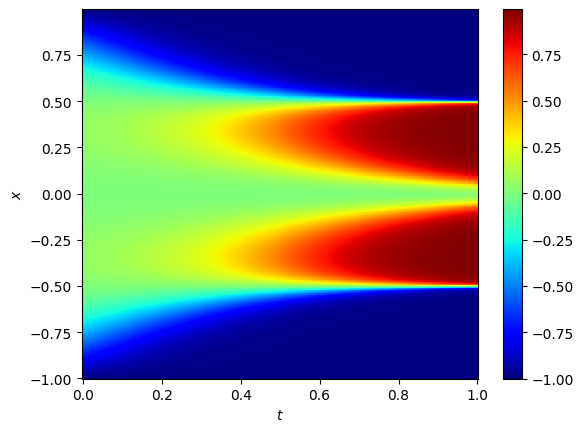

In [4]:
# load the data
data = scipy.io.loadmat('AC.mat')
usol = data['uu']

# Grid
t_star = data['tt'][0]
x_star = data['x'][0]
TT, XX = np.meshgrid(t_star, x_star)

# Reference solution
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')

In [5]:
 # Create PINNs model
key = random.PRNGKey(1234)

# Network architecture
M = 10
d0 = M * 2 + 2
layers = [d0, 128, 128, 128, 128, 1]

# hpyer-parameters
nu = 0.0001
t0 = 0.0
t1 = 1.0
n_t = 100
n_x = 256
tol = 100

state0 = usol[:, 0:1]

model = PINN(key, layers, M, state0, t0, t1, n_t, n_x, tol)

In [6]:
# Train
model.train(nIter=100000)

100%|█| 100000/100000 [56:13<00:00, 29.64it/s, Loss=1.41068385e-05, loss_ics=2.9


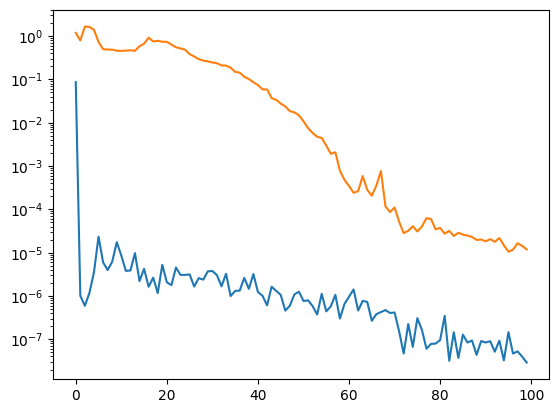

In [7]:
plt.plot(model.loss_ics_log)
plt.plot(model.loss_res_log)
plt.yscale('log')

In [8]:
# Get trained network parameters
params = model.get_params(model.opt_state)
u_pred = model.u_pred_fn(params, t_star, x_star)
error = np.linalg.norm(u_pred - usol) / np.linalg.norm(usol) 
print('Relative l2 error: {:.3e}'.format(error))

Relative l2 error: 4.264e-03


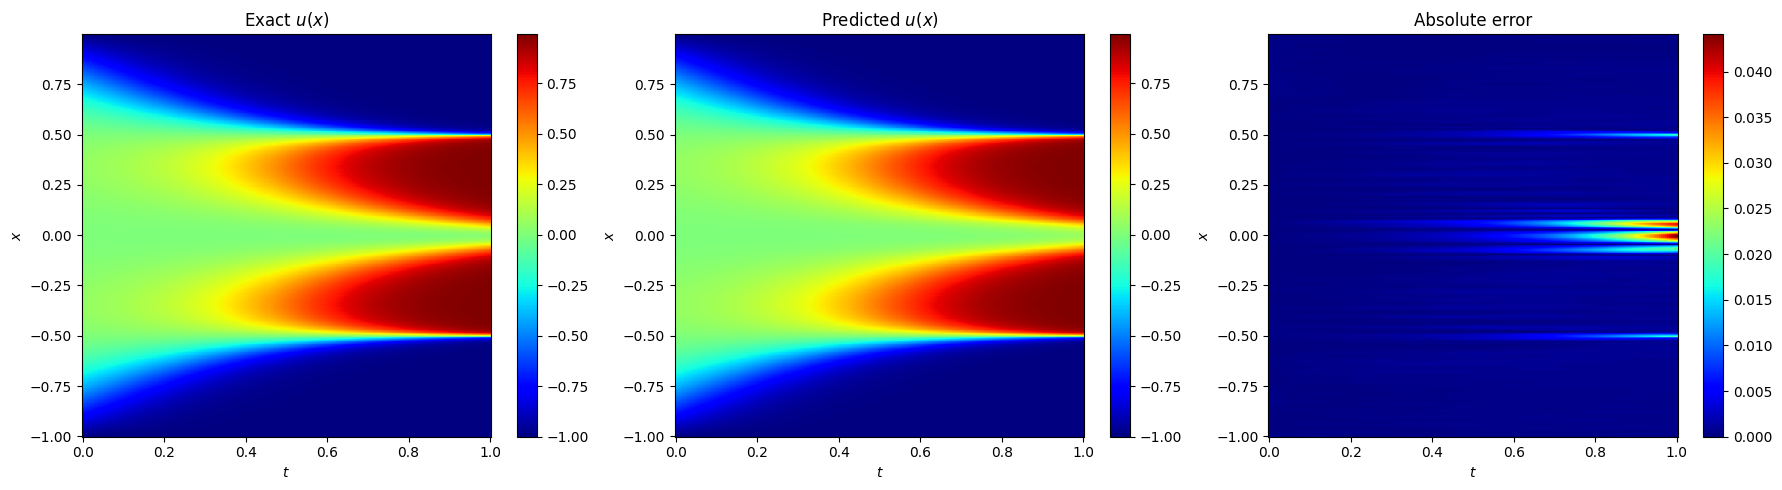

In [9]:
fig = plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Exact $u(x)$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Predicted $u(x)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, np.abs(usol - u_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Absolute error')
plt.tight_layout()
plt.show()

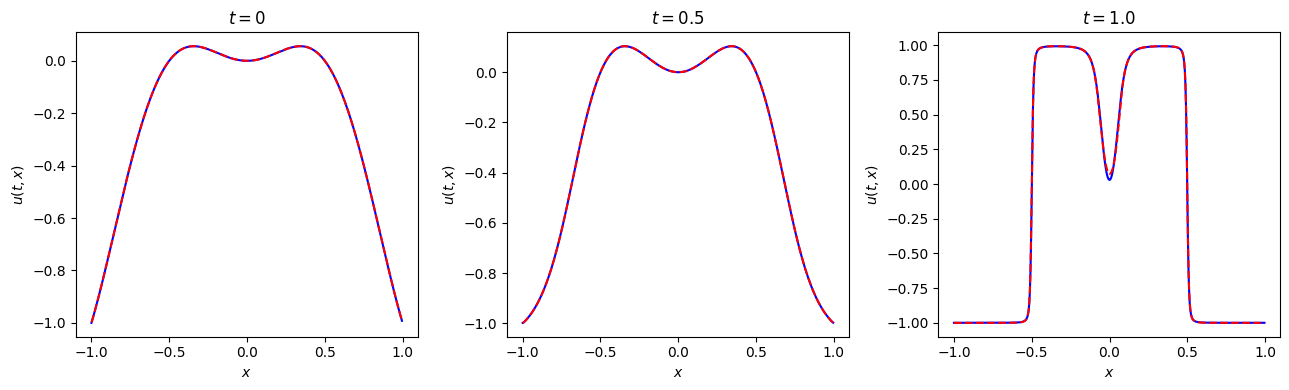

In [10]:
fig = plt.figure(figsize=(13, 4))
plt.subplot(1, 3, 1)
plt.plot(x_star, usol[:,0], color='blue')
plt.plot(x_star, u_pred[:,0], '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 0$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.plot(x_star, usol[:,25], color='blue')
plt.plot(x_star, u_pred[:,25], '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 0.5$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.plot(x_star, usol[:,-1], color='blue')
plt.plot(x_star, u_pred[:,-1], '--', color='red')
plt.xlabel('$x$')
plt.ylabel('$u(t, x)$')
plt.title('$t = 1.0$')
plt.tight_layout()
plt.show()

In [11]:
L_t, W = model.residuals_and_weights(params, model.tol)

Text(0, 0.5, '$w(t)$')

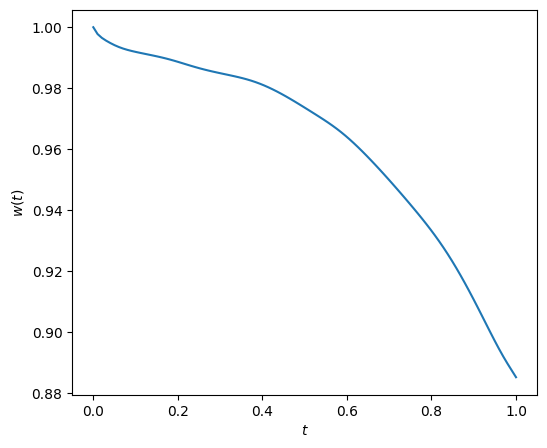

In [12]:
fig = plt.figure(figsize=(6, 5))
plt.plot(model.t_r, W)
plt.xlabel('$t$')
plt.ylabel('$w(t)$')

Text(0, 0.5, '$\\mathcal{L}(t, \\theta)$')

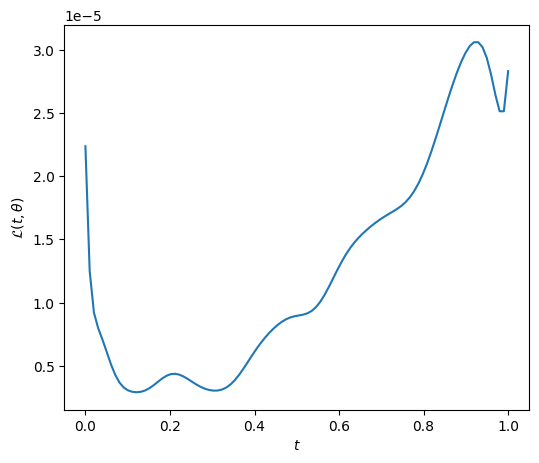

In [13]:
fig = plt.figure(figsize=(6, 5))
plt.plot(model.t_r, L_t)
plt.xlabel('$t$')
plt.ylabel('$\mathcal{L}(t, \\theta)$')